In [94]:
import pandas as pd 
import missingno as msno 
import numpy as np 
import seaborn as sms
from datetime import datetime as dt 
import matplotlib.pyplot as plt
import plotly.express as px 
from dash import Dash, dcc, html, Input, Output
import sklearn 
from sklearn.linear_model import LinearRegression, Ridge   
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


pd.options.display.max_columns = 150 
pd.options.display.max_rows = 150 

## Recuperation du CSV
### On crée 2 dataset, un avec notre Target (y), ici 'price' , la deuxième avec toutes les features qu'on juge utiles

In [23]:
df_modelisation = pd.read_csv('df2.csv')
df_modelisation_prix = df_modelisation[['price']]
df_modelisation_prix.head()

,price
0,221900.0
1,538000.0
2,180000.0
3,604000.0
4,510000.0


In [80]:
df_modelisation2 = df_modelisation[['sqft_living','grade','sqft_above','sqft_living15','bathrooms','view','sqft_basement',
'bedrooms','zipcode_98004','waterfront','floors','zipcode_98039','zipcode_98040','zipcode_98112','zipcode_98006',
'yr_renovated','zipcode_98033','zipcode_98105','sqft_lot','zipcode_98075','zipcode_98199','sqft_lot15','zipcode_98001',
'zipcode_98042','zipcode_98023']]
df_modelisation2.head(2)

,sqft_living,grade,sqft_above,sqft_living15,bathrooms,view,sqft_basement,bedrooms,zipcode_98004,waterfront,floors,zipcode_98039,zipcode_98040,zipcode_98112,zipcode_98006,yr_renovated,zipcode_98033,zipcode_98105,sqft_lot,zipcode_98075,zipcode_98199,sqft_lot15,zipcode_98001,zipcode_98042,zipcode_98023
0,1180,7,1180,1340,1.00,0,0,3,0,0,1.0,0,0,0,0,0,0,0,5650,0,0,5650,0,0,0
1,2570,7,2170,1690,2.25,0,400,3,0,0,2.0,0,0,0,0,1991,0,0,7242,0,0,7639,0,0,0


### StandardScaler

In [99]:
""" X = df_modelisation2.values
y = df_modelisation.price.values
X_standard = StandardScaler().fit_transform(X).mean()
X_standard """

' X = df_modelisation2.values\ny = df_modelisation.price.values\nX_standard = StandardScaler().fit_transform(X).mean()\nX_standard '

### Modèle de regression linéaire

In [98]:

from sklearn.pipeline import make_pipeline


model = make_pipeline(PolynomialFeatures(2), LinearRegression())

X = df_modelisation2.values
y = df_modelisation.price.values
X_train, X_test,y_train , y_test = train_test_split(X, y, test_size=0.2)
model.fit(X_train, y_train)

print("----train-----")
print (model.score(X_train,y_train))
print ("----test----")
print(model.score(X_test,y_test))
# model.predict(X_test)   A quoi servent ces données? 


----train-----
0.8222338283553066
----test----
0.7781355296379615


## Modélisation de la méthode de régression linéaire

ValueError: x and y must be the same size

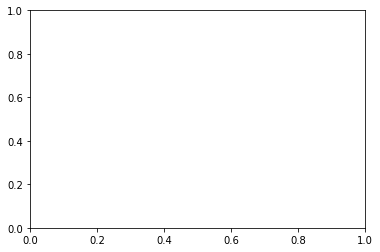

In [55]:
plt.scatter(X, y)
plt.plot(X, model.predict(X), c='red')

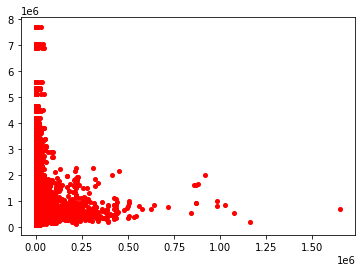

In [44]:
plt.plot(df_modelisation2 , df_modelisation_prix,'ro', markersize = 4) #UTILISATION DE LA FONCTION PLOT 
plt.show()


ValueError: x and y must be the same size

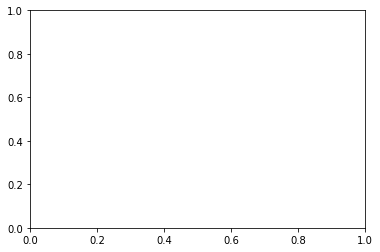

In [39]:
predictions = model.predict(X_test)
plt.scatter(X_test,y)
plt.plot(X, predictions, c='r')

## Fonction qui permet de prédire le prix d'une maison

In [ ]:
def prediction_maison(model,sqft_living	,grade	,sqft_above	,sqft_living15	,bathrooms,	view	,sqft_basement	,
                bedrooms	,zipcode_98004	,waterfront	,floors	,zipcode_98039,	zipcode_98040	,zipcode_98112,	zipcode_98006,	yr_renovated	,
                zipcode_98033,	zipcode_98105	,sqft_lot,	zipcode_98075,	zipcode_98199	,
                sqft_lot15 ,	zipcode_98001,	zipcode_98042,	zipcode_98023):
    x = np.array([sqft_living	,grade	,sqft_above	,sqft_living15	,bathrooms,	view	,sqft_basement	,
                bedrooms	,zipcode_98004	,waterfront	,floors	,zipcode_98039,	zipcode_98040	,zipcode_98112,	zipcode_98006,	yr_renovated	,
                zipcode_98033,	zipcode_98105	,sqft_lot,	zipcode_98075,	zipcode_98199	,
                sqft_lot15 ,	zipcode_98001,	zipcode_98042,	zipcode_98023]).reshape(1,25)
    print (model.predict(x))


In [100]:
#essai de la fonction
prediction_maison(model,50,7,30,48,2,2,0,2,1,0,1,0,0,0,0,1988,0,0,35,0,0,40,0,0,0)

[336165.19884667 597567.26812158 374180.46084008 ... 391944.43472467
 434180.40680871 393096.10973153]
-----------


AttributeError: 'LinearRegression' object has no attribute 'predict_proba'

## Utilisation de Ridge (variante de l'algorithme de régression linéaire)

In [17]:
rid = Ridge(10).fit(X_train, y_train)
r2_score(y_test, rid.predict(X_test))


NameError: name 'r2_score' is not defined